#Problem 2: Dimensionality reduction
Consider a dataset where M neurons are recorded during repeated trials of a reach task. The resulting data is a number of matrices (one per trial) that is N ×T (number of neurons by time - in 1 ms bins) where Xit represents the number of spikes for neuron i during the time-bin t. This problem will consider the dimensionality reduction approach of finding the underlying patterns of neural activity common across trials. Specifically we will first look at standard PCA before and after processing (to highlight the benefit of priors over spike-rates). We will then look at applying an external package that finds smooth spike-rates underlying the neural activity automatically (Gaussian Process Factor Analysis).

##Part B
Compute the Principal components of the PSTH matrix, both with and without smoothing. Look at the temporal principal components. Specifically, plot (side-by-side) the top 3 components as a 3D line plot. What do you notice?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


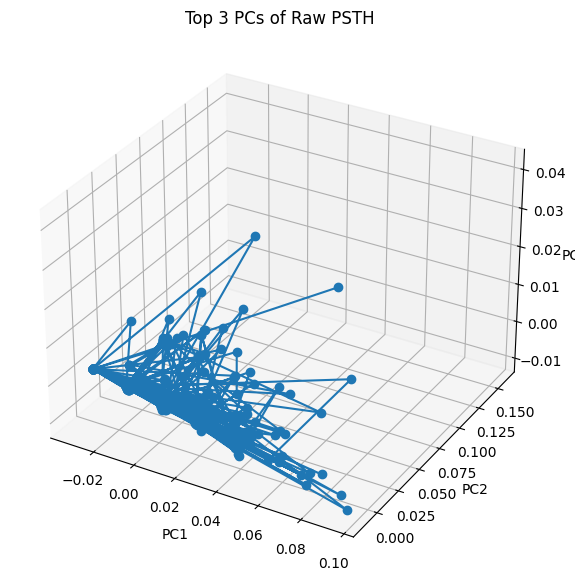

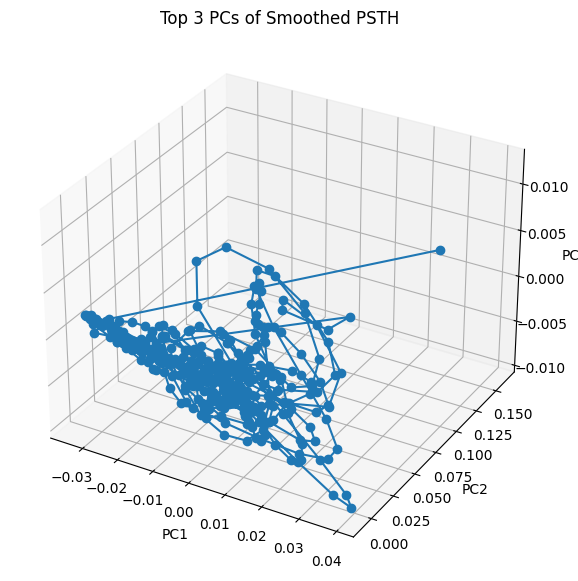

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def do_pca(psth, n_components=3):
  pca = PCA(n_components=n_components)
  pca_components = pca.fit_transform(psth.T)
  return pca_components.T

# Find the file in google drive
drive.mount('/content/drive')
file = "/content/drive/MyDrive/Neural_Signals_and_Computation_HW2/sample_dat.mat"

import scipy.io as sio
mat_contents = sio.loadmat(file)
data_trials = mat_contents['dat'][0]

## Make Perstimulus Time Histograms
raw_psth = []
smooth_psth = []
bins = np.arange(0, 0.4 + 0.001, 0.001)
for i in range(len(data_trials[0][1])):
  total = []
  for trials in data_trials:
    # This is number of spikes for Neuron i at time bin n (1 msec bins)
    n1 = []
    for j in range(len(trials[1][i])):
      if trials[1][0][j] * 0.001 != 0:
        for k in range(trials[1][i][j]):
          n1.append(0.001 * j)
      elif j == 0 and trials[1][i][j] > 0:
        for k in range(trials[1][i][j]):
          n1.append(0.001 * j)
    if total is not None:
      total += n1
    else:
      total = n1

  y = np.histogram(total, bins=bins)[0] / len(data_trials)
  raw_psth.append(y)

# Conduct Gaussian Process
raw_psth = np.array(raw_psth)
time_bins = bins[:-1]

kernel = ConstantKernel(1, (1e-2, 1e2)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

import warnings
warnings.filterwarnings("ignore")

smoothed_psth = np.zeros_like(raw_psth)
for n in range(raw_psth.shape[0]):
  gp.fit(time_bins[:, np.newaxis], raw_psth[n, :])
  smoothed_psth[n, :] = gp.predict(time_bins[:, np.newaxis])

# Compute PCA on raw and smoothed PSTHs
raw_pca = do_pca(raw_psth, n_components=3)
smoothed_pca = do_pca(smoothed_psth, n_components=3)

# Function to plot 3D principal components
def plot_3d_pca(pca_components, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(pca_components[0], pca_components[1], pca_components[2], marker='o')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)
    plt.show()

# Plot the top 3 principal components for raw and smoothed PSTHs
plot_3d_pca(raw_pca, "Top 3 PCs of Raw PSTH")
plot_3d_pca(smoothed_pca, "Top 3 PCs of Smoothed PSTH")

It appears that the smoothed version of the PCA with the PSTH has some swirling pattern when we plot the 3 principal components as a 3d line plot while the same can not be said for the raw version.